In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [30]:
#1. Data Loading and Initial Exploration

# Load the dataset
df = pd.read_csv('personality_dataset.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 8)

First 5 rows:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert  

Data types and missing values:
<class 'p

In [31]:
#2. Data Cleaning and Preprocessing


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values
# For numerical columns, we'll impute with median
# For categorical columns, we'll impute with mode

# Separate features and target
X = df.drop('Personality', axis=1)
y = df['Personality']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Added scaling for numerical features
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())  # Changed from LabelEncoder to OrdinalEncoder
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Convert back to DataFrame (for easier handling)
processed_cols = list(num_cols) + list(cat_cols)
X_processed = pd.DataFrame(X_processed, columns=processed_cols)

# Encode target variable (using LabelEncoder is fine here)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Verify encoding
print("\nClass distribution:")
print(pd.Series(y_encoded).value_counts())
print("0 =", label_encoder.inverse_transform([0])[0])
print("1 =", label_encoder.inverse_transform([1])[0])

Missing values per column:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64

Class distribution:
0    1491
1    1409
Name: count, dtype: int64
0 = Extrovert
1 = Introvert


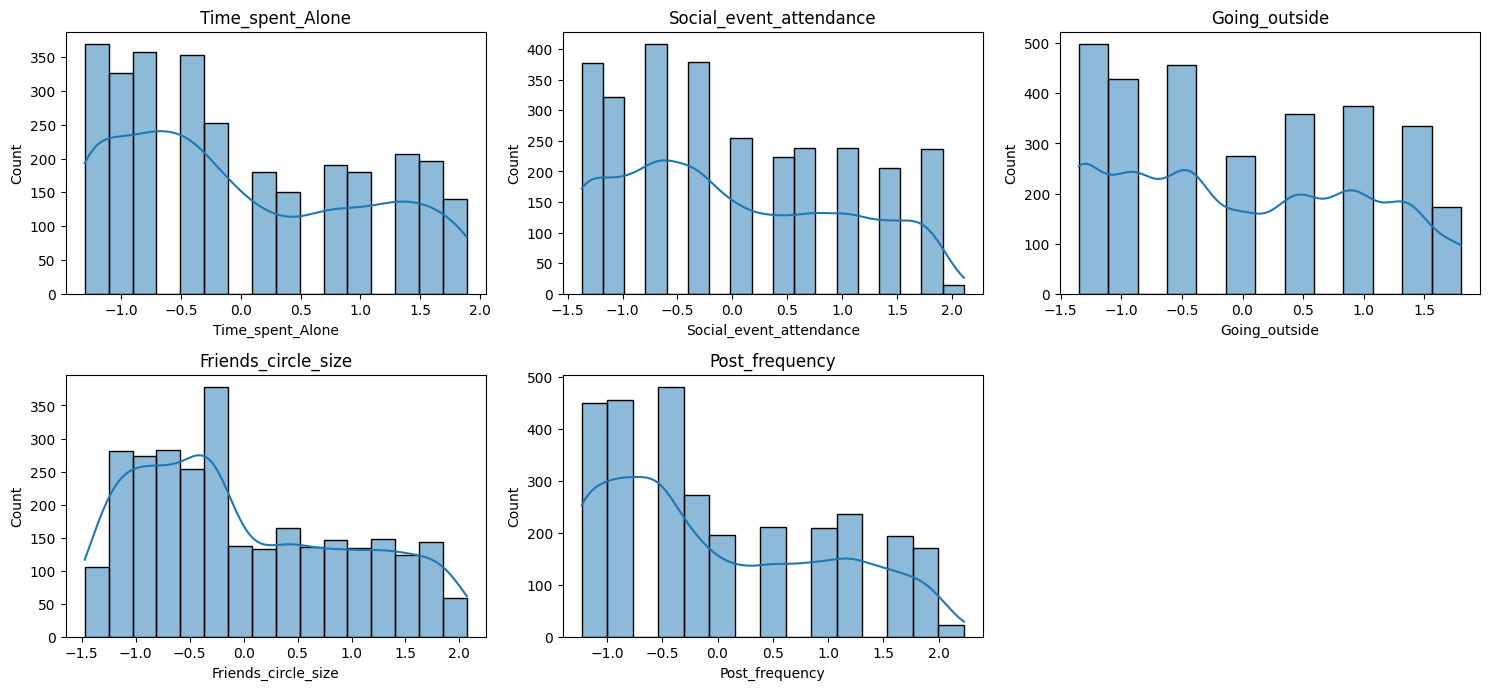

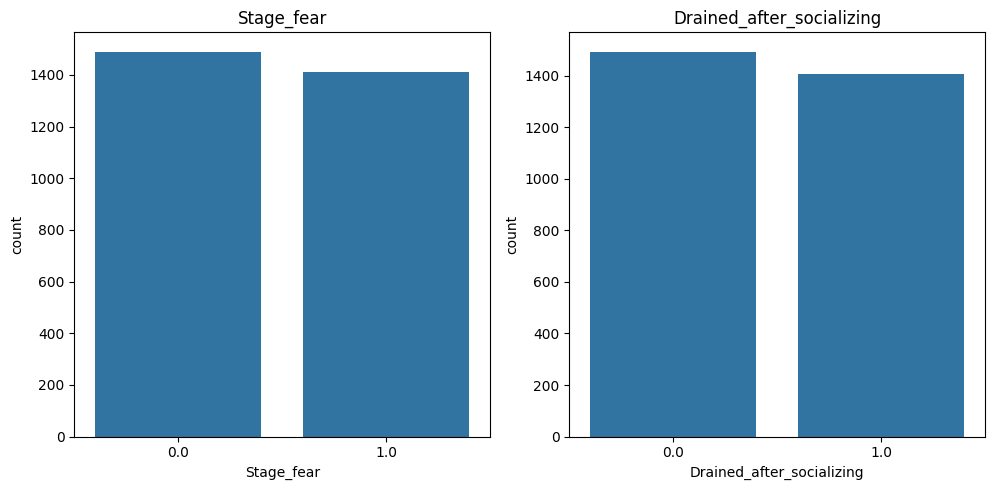

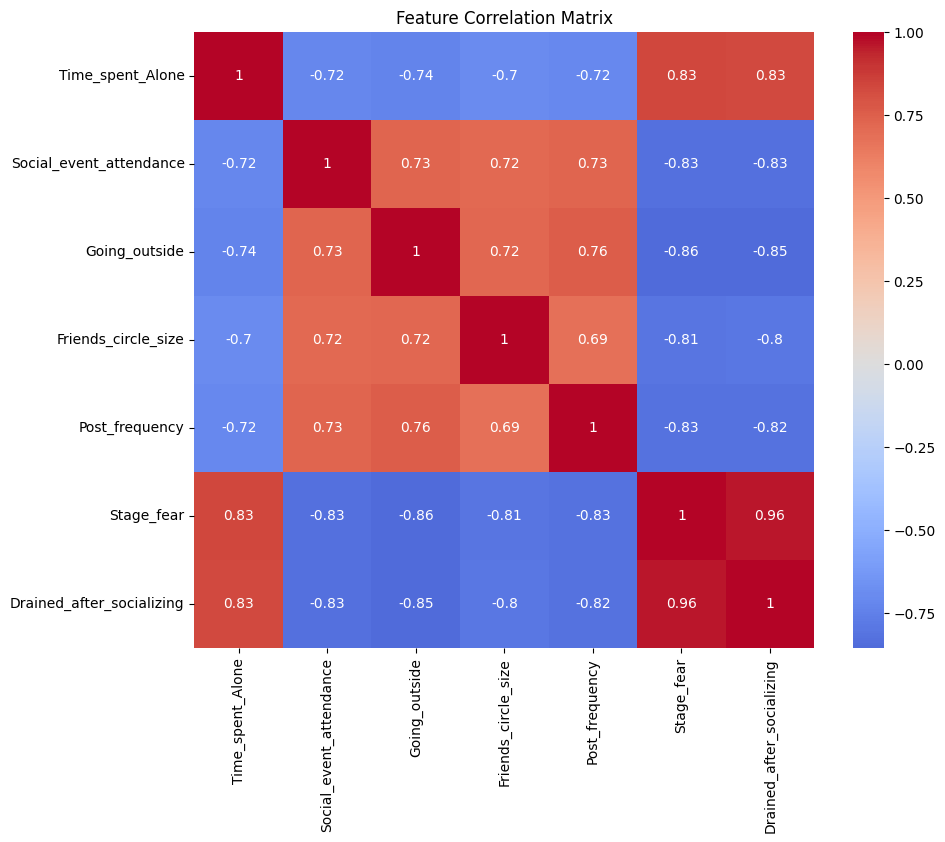

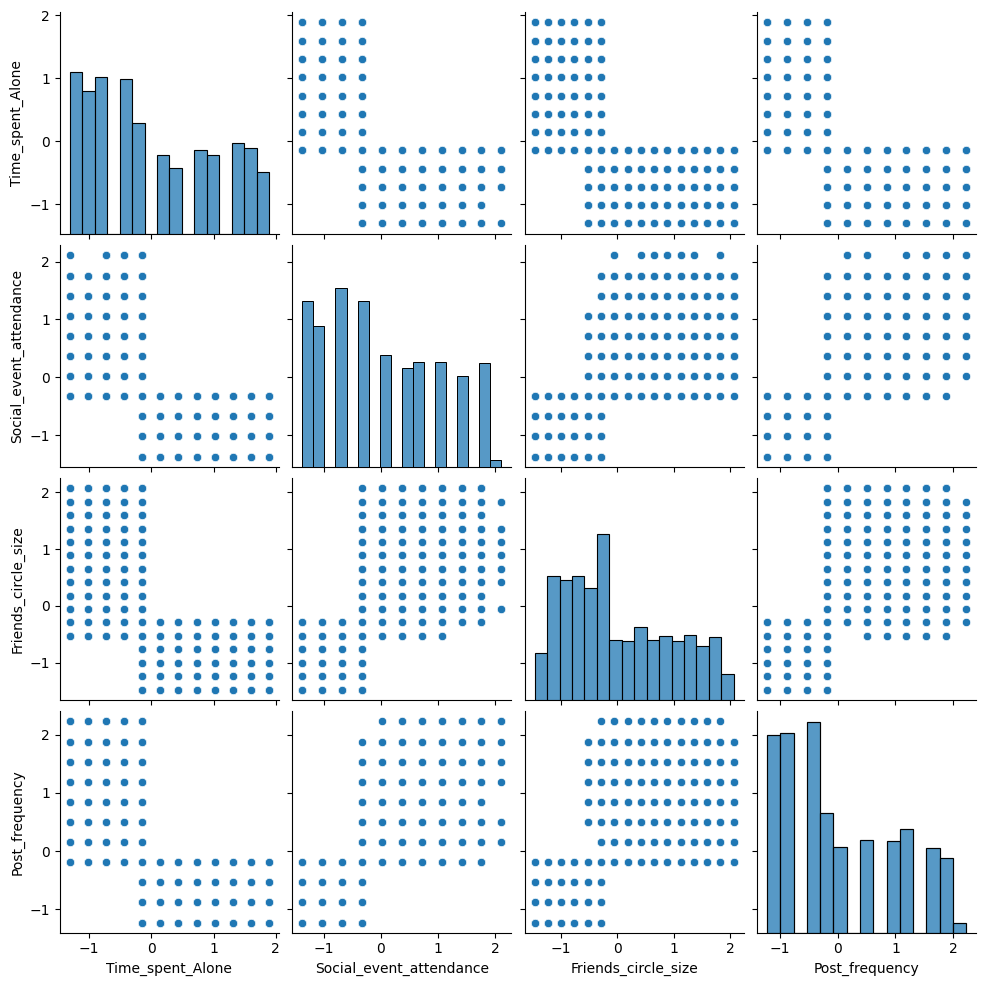

In [32]:
#3. Exploratory Data Analysis (EDA)


# Visualize distribution of numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_processed[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Visualize distribution of categorical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=X_processed[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = X_processed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Pairplot of selected features
sns.pairplot(X_processed[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size', 'Post_frequency']])
plt.show()

In [33]:
#4. Feature Engineering



# We'll create some additional features that might be useful
X_processed['Social_Activity_Index'] = X_processed['Social_event_attendance'] + X_processed['Going_outside']
X_processed['Social_Engagement_Ratio'] = X_processed['Friends_circle_size'] / (X_processed['Time_spent_Alone'] + 1)  # +1 to avoid division by zero

# Check the new features
print(X_processed[['Social_Activity_Index', 'Social_Engagement_Ratio']].describe())

# Drop original columns if needed (optional)
# X_processed = X_processed.drop(['Social_event_attendance', 'Going_outside'], axis=1)

       Social_Activity_Index  Social_Engagement_Ratio
count           2.900000e+03              2900.000000
mean           -9.800589e-18                -5.842665
std             1.861373e+00                22.308483
min            -2.721773e+00              -133.203198
25%            -1.678473e+00                -0.891880
50%             1.990665e-02                -0.384537
75%             1.718286e+00                 0.210849
max             3.907324e+00                33.968964


Random Forest Baseline Model Performance:

Accuracy: 0.8982758620689655

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       298
           1       0.89      0.90      0.90       282

    accuracy                           0.90       580
   macro avg       0.90      0.90      0.90       580
weighted avg       0.90      0.90      0.90       580



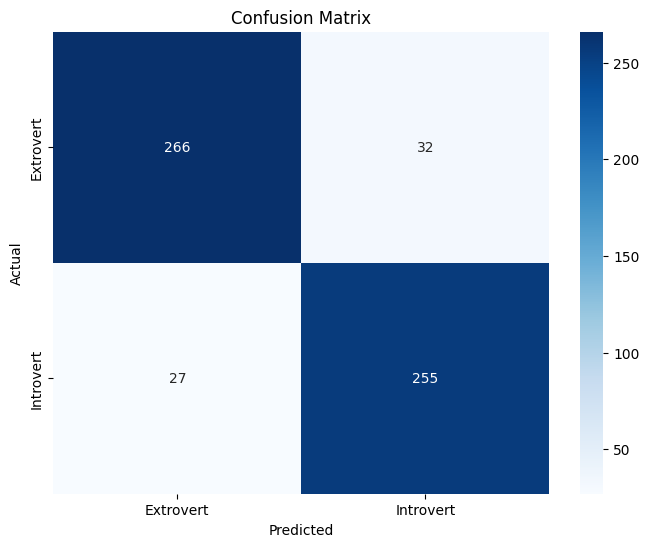

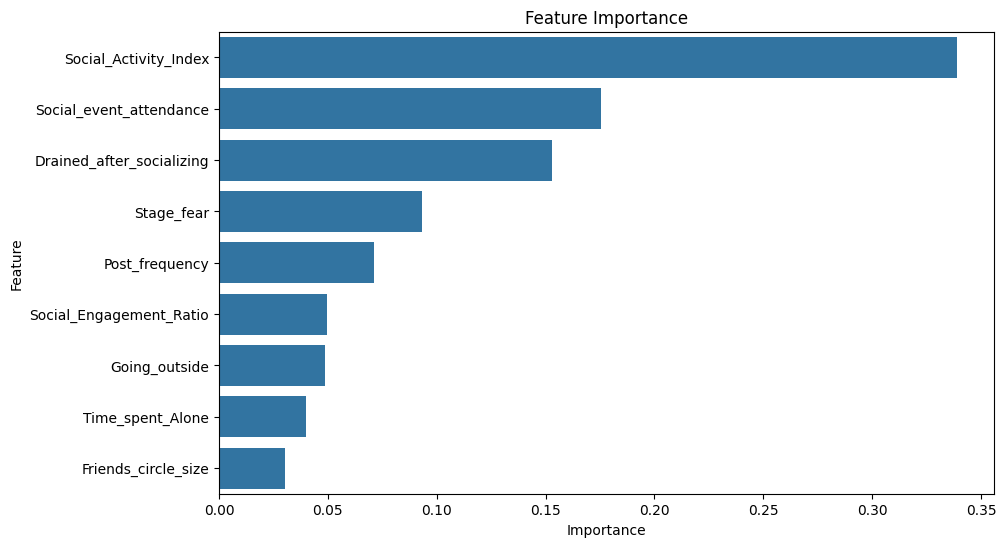

In [34]:
#5. Model Training (Random Forest)



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Random Forest Baseline Model Performance:")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Tuned Random Forest Model Performance:

Accuracy: 0.9155172413793103

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       298
           1       0.89      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



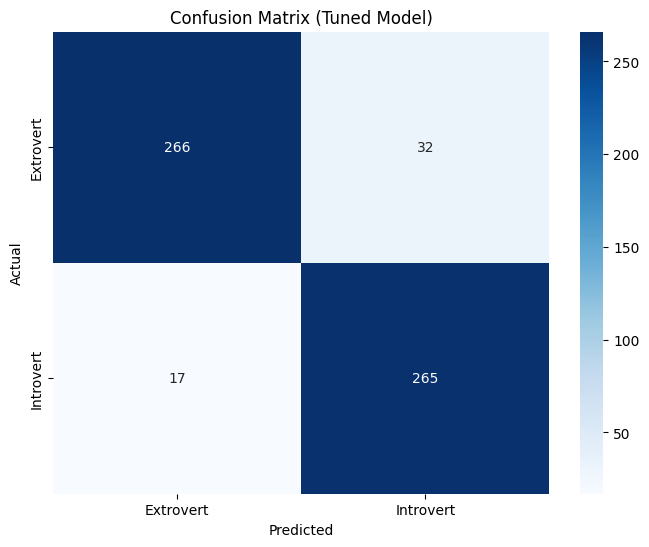

In [10]:
#6. Hyperparameter Tuning (GridSearchCV)



# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate best model
y_pred_best = best_rf.predict(X_test)

print("\nTuned Random Forest Model Performance:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix for best model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
#7. Model Evaluation and Comparison


# Compare baseline and tuned models
baseline_acc = accuracy_score(y_test, y_pred)
tuned_acc = accuracy_score(y_test, y_pred_best)

print(f"Baseline Model Accuracy: {baseline_acc:.4f}")
print(f"Tuned Model Accuracy: {tuned_acc:.4f}")
print(f"Improvement: {(tuned_acc - baseline_acc)*100:.2f}%")

# Cross-validate the best model
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf, X_processed, y_encoded, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Baseline Model Accuracy: 0.8983
Tuned Model Accuracy: 0.9155
Improvement: 1.72%

Cross-Validation Scores: [0.96034483 0.93275862 0.92931034 0.91551724 0.9137931 ]
Mean CV Accuracy: 0.9303448275862068
Standard Deviation: 0.01673746358553322


In [36]:
#8. Final Model Selection and Saving




# Train final model on all data
final_model = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features'],
    random_state=42
)

final_model.fit(X_processed, y_encoded)

# Save the model and preprocessing objects
joblib.dump(final_model, 'personality_predictor_rf_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model and preprocessing objects saved successfully.")

Model and preprocessing objects saved successfully.


In [37]:
#9. Prediction Function (for demonstration)


def predict_personality(features):
    """
    Corrected prediction function that:
    1. Explicitly verifies class-label mapping
    2. Ensures probabilities align with expected classes
    3. Always returns the class with highest probability
    """
    # Load saved objects
    model = joblib.load('personality_predictor_rf_model.pkl')
    preprocessor = joblib.load('preprocessor.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    # Verify class mapping
    print(f"Model classes: {model.classes_}")  # Should show [0, 1]
    print(f"Label encoder classes: {label_encoder.classes_}")  # Should show ['Extrovert', 'Introvert'] or vice versa
    
    # List of ALL original features used during training
    original_features = [
        'Time_spent_Alone',
        'Stage_fear',
        'Social_event_attendance',
        'Going_outside',
        'Drained_after_socializing',
        'Friends_circle_size',
        'Post_frequency'
    ]
    
    # Create input DataFrame
    input_df = pd.DataFrame(columns=original_features)
    for feature in original_features:
        if feature in features:
            if feature in ['Stage_fear', 'Drained_after_socializing']:
                input_df[feature] = [str(features[feature])]
            else:
                input_df[feature] = [float(features[feature])]
        else:
            if feature in ['Stage_fear', 'Drained_after_socializing']:
                input_df[feature] = ['No']
            else:
                input_df[feature] = [0.0]
    
    # Add engineered features
    processed_data = preprocessor.transform(input_df)
    social_activity = input_df['Social_event_attendance'] + input_df['Going_outside']
    social_engagement = input_df['Friends_circle_size'] / (input_df['Time_spent_Alone'] + 1)
    final_features = np.column_stack([processed_data, social_activity, social_engagement])
    
    # Get probabilities and verify order
    probabilities = model.predict_proba(final_features)[0]
    print(f"Raw probabilities: {probabilities}")
    
    # Ensure probability order matches class labels
    if label_encoder.classes_[0] == 'Introvert':
        introvert_prob = probabilities[0]
        extrovert_prob = probabilities[1]
    else:
        introvert_prob = probabilities[1]
        extrovert_prob = probabilities[0]
    
    # Determine prediction
    prediction = 'Introvert' if introvert_prob > extrovert_prob else 'Extrovert'
    confidence = max(introvert_prob, extrovert_prob)
    
    return {
        'prediction': prediction,
        'probability_introvert': float(introvert_prob),
        'probability_extrovert': float(extrovert_prob),
        'confidence': float(confidence)
    }

# Test cases
test_cases = [
    {
        'Time_spent_Alone': 10.0,
        'Stage_fear': 'Yes',
        'Social_event_attendance': 1.0,
        'Going_outside': 1.0,
        'Drained_after_socializing': 'Yes',
        'Friends_circle_size': 2.0,
        'Post_frequency': 1.0
    },
    {
        'Time_spent_Alone': 2.0,
        'Stage_fear': 'No',
        'Social_event_attendance': 8.0,
        'Going_outside': 6.0,
        'Drained_after_socializing': 'No',
        'Friends_circle_size': 15.0,
        'Post_frequency': 9.0
    }
]

for i, test_input in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    try:
        result = predict_personality(test_input)
        print("\nPrediction Results:")
        print(f"Predicted Personality: {result['prediction']}")
        print(f"Introvert Probability: {result['probability_introvert']:.4f}")
        print(f"Extrovert Probability: {result['probability_extrovert']:.4f}")
        print(f"Confidence: {result['confidence']:.2f}")
        
        if abs(result['probability_introvert'] - result['probability_extrovert']) < 0.1:
            print("Note: Borderline case - small probability difference")
    except Exception as e:
        print(f"Prediction failed: {str(e)}")


Test Case 1:
Model classes: [0 1]
Label encoder classes: ['Extrovert' 'Introvert']
Raw probabilities: [0.50471358 0.49528642]

Prediction Results:
Predicted Personality: Extrovert
Introvert Probability: 0.4953
Extrovert Probability: 0.5047
Confidence: 0.50
Note: Borderline case - small probability difference

Test Case 2:
Model classes: [0 1]
Label encoder classes: ['Extrovert' 'Introvert']
Raw probabilities: [0.8177601 0.1822399]

Prediction Results:
Predicted Personality: Extrovert
Introvert Probability: 0.1822
Extrovert Probability: 0.8178
Confidence: 0.82
